# Lab | Unsupervised learning intro

Instructions

It's the moment to perform clustering on the songs you collected.

Remember that the ultimate goal of this little project is to improve the recommendations of artists. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.


The experiments you did with the Spotify API and the Billboard web scraping will allow you to create a pipeline such that when the user enters a song, you:


1. Check whether or not the song is in the Billboard Hot 200.
2. Collect the audio features from the Spotify API.


After that, you want to send the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.

#### Clustering

In [247]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from random import randint
from time import sleep
import random
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials


In [248]:
playlist_db_all = pd.read_excel('playlist_db_all.xlsx')
playlist_db_all.columns = playlist_db_all.columns.str.lower()
playlist_db_all

,unnamed: 0,music,artist,album,audio_features_0_danceability,audio_features_0_energy,audio_features_0_key,audio_features_0_loudness,audio_features_0_mode,audio_features_0_speechiness,...,audio_features_0_liveness,audio_features_0_valence,audio_features_0_tempo,audio_features_0_type,audio_features_0_id,audio_features_0_uri,audio_features_0_track_href,audio_features_0_analysis_url,audio_features_0_duration_ms,audio_features_0_time_signature
0,0,Miniyamba,Yeahman,Shika Shika / Botanas Series,0.702,0.5080,4,-9.474,0,0.0457,...,0.9150,0.659,89.004,audio_features,5LLfL25W8ELqVXOLBhkJOP,spotify:track:5LLfL25W8ELqVXOLBhkJOP,https://api.spotify.com/v1/tracks/5LLfL25W8ELq...,https://api.spotify.com/v1/audio-analysis/5LLf...,250787,4
1,1,We,Marava,We EP,0.867,0.4000,2,-10.431,0,0.0542,...,0.1150,0.219,117.972,audio_features,0tujxzW3mEM6CnS0PK0Fcb,spotify:track:0tujxzW3mEM6CnS0PK0Fcb,https://api.spotify.com/v1/tracks/0tujxzW3mEM6...,https://api.spotify.com/v1/audio-analysis/0tuj...,215593,4
2,2,Quién Me Escucha,Sandra Bernardo,Quién Me Escucha,0.746,0.5300,11,-10.645,0,0.2720,...,0.0773,0.574,182.020,audio_features,19e0zVRwZdpid0bGdYXxGi,spotify:track:19e0zVRwZdpid0bGdYXxGi,https://api.spotify.com/v1/tracks/19e0zVRwZdpi...,https://api.spotify.com/v1/audio-analysis/19e0...,198150,4
3,3,Kompaz,Rodrigo Gallardo,Harabe Daydreams I,0.788,0.4930,11,-13.009,0,0.0741,...,0.0979,0.244,108.036,audio_features,0E5zTpx6xHATfDox2qMNHY,spotify:track:0E5zTpx6xHATfDox2qMNHY,https://api.spotify.com/v1/tracks/0E5zTpx6xHAT...,https://api.spotify.com/v1/audio-analysis/0E5z...,395556,4
4,4,"Monday (feat. LEJ, Akhenaton & Blundetto)",Biga*Ranx,1988,0.945,0.4600,11,-6.892,0,0.0573,...,0.0858,0.736,130.065,audio_features,5IZBQqDymS1bDGmesVFC8N,spotify:track:5IZBQqDymS1bDGmesVFC8N,https://api.spotify.com/v1/tracks/5IZBQqDymS1b...,https://api.spotify.com/v1/audio-analysis/5IZB...,177813,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,1638,Que reste-t-il de nos amours ? - Bonus track,Stacey Kent,Raconte-moi... (Bonus Edition),0.534,0.0889,9,-17.076,1,0.0892,...,0.1100,0.186,173.205,audio_features,7vY7W8DL8JSaS6aBDFHGW3,spotify:track:7vY7W8DL8JSaS6aBDFHGW3,https://api.spotify.com/v1/tracks/7vY7W8DL8JSa...,https://api.spotify.com/v1/audio-analysis/7vY7...,163510,4
1639,1639,Barry White,Fredda,Toutes mes aventures,0.655,0.4490,9,-8.945,0,0.0251,...,0.2940,0.587,90.077,audio_features,3AOHmD0knWrkPCuu4l1Hbb,spotify:track:3AOHmD0knWrkPCuu4l1Hbb,https://api.spotify.com/v1/tracks/3AOHmD0knWrk...,https://api.spotify.com/v1/audio-analysis/3AOH...,195160,4
1640,1640,Raconte-moi...,Stacey Kent,Raconte-moi... (Bonus Edition),0.718,0.2550,6,-13.892,0,0.0451,...,0.1050,0.273,123.971,audio_features,2lvlrhaZrPws3DSoZ14hcL,spotify:track:2lvlrhaZrPws3DSoZ14hcL,https://api.spotify.com/v1/tracks/2lvlrhaZrPws...,https://api.spotify.com/v1/audio-analysis/2lvl...,222817,4
1641,1641,Que reste t-il de nos amours,Cyntia M.,Bistro Blue,0.616,0.1960,0,-12.266,1,0.0553,...,0.1580,0.303,121.772,audio_features,3rUVcKmdmAjJEt0Zx7nSL5,spotify:track:3rUVcKmdmAjJEt0Zx7nSL5,https://api.spotify.com/v1/tracks/3rUVcKmdmAjJ...,https://api.spotify.com/v1/audio-analysis/3rUV...,211440,4


In [249]:
#select the features to cluster
numeric = playlist_db_all[['audio_features_0_danceability','audio_features_0_energy',
                                                 'audio_features_0_key','audio_features_0_loudness',
                                                  'audio_features_0_mode', 'audio_features_0_speechiness',
                                                 'audio_features_0_acousticness', 'audio_features_0_instrumentalness',
                                                 'audio_features_0_liveness', 'audio_features_0_valence',
                                                 'audio_features_0_tempo', 'audio_features_0_duration_ms',
                                                 'audio_features_0_time_signature']].apply(pd.to_numeric)

In [250]:
#Scale audio features with MinMaxScaler

#Choose to use this method as there is no reason to emphasize certain features over the others

MinMaxtransformer = MinMaxScaler().fit(numeric)
X_prep = MinMaxtransformer.transform(numeric)
X_prep = pd.DataFrame(X_prep,columns=numeric.columns)
X_prep

,audio_features_0_danceability,audio_features_0_energy,audio_features_0_key,audio_features_0_loudness,audio_features_0_mode,audio_features_0_speechiness,audio_features_0_acousticness,audio_features_0_instrumentalness,audio_features_0_liveness,audio_features_0_valence,audio_features_0_tempo,audio_features_0_duration_ms,audio_features_0_time_signature
0,0.712690,0.510553,0.363636,0.748990,0.0,0.091583,0.547189,0.962702,0.929878,0.673136,0.437115,0.378175,0.8
1,0.880203,0.402010,0.181818,0.726781,0.0,0.108617,0.110442,0.924395,0.116870,0.223698,0.579382,0.324450,0.8
2,0.757360,0.532663,1.000000,0.721815,0.0,0.545090,0.250000,0.214718,0.078557,0.586313,0.893933,0.297822,0.8
3,0.800000,0.495477,1.000000,0.666953,0.0,0.148497,0.054719,0.916331,0.099492,0.249234,0.530584,0.599174,0.8
4,0.959391,0.462312,1.000000,0.808912,0.0,0.114830,0.157631,0.000000,0.087195,0.751788,0.638773,0.266776,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.542132,0.089347,0.818182,0.572569,1.0,0.178758,0.971888,0.047480,0.111789,0.189990,0.850641,0.244942,0.8
1639,0.664975,0.451256,0.818182,0.761267,0.0,0.050301,0.679719,0.000004,0.298780,0.599591,0.442384,0.293258,0.8
1640,0.728934,0.256281,0.545455,0.646461,0.0,0.090381,0.878514,0.000030,0.106707,0.278856,0.608844,0.335478,0.8
1641,0.625381,0.196985,0.000000,0.684196,1.0,0.110822,0.854418,0.000000,0.160569,0.309499,0.598044,0.318110,0.8


In [251]:
#Sclale audio features
# X_prep = StandardScaler().fit_transform(playlist_db_all_audio_features)
# X_prep_df = pd.DataFrame(X_prep,columns=playlist_db_all_audio_features.columns).head()
# X_prep_df

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

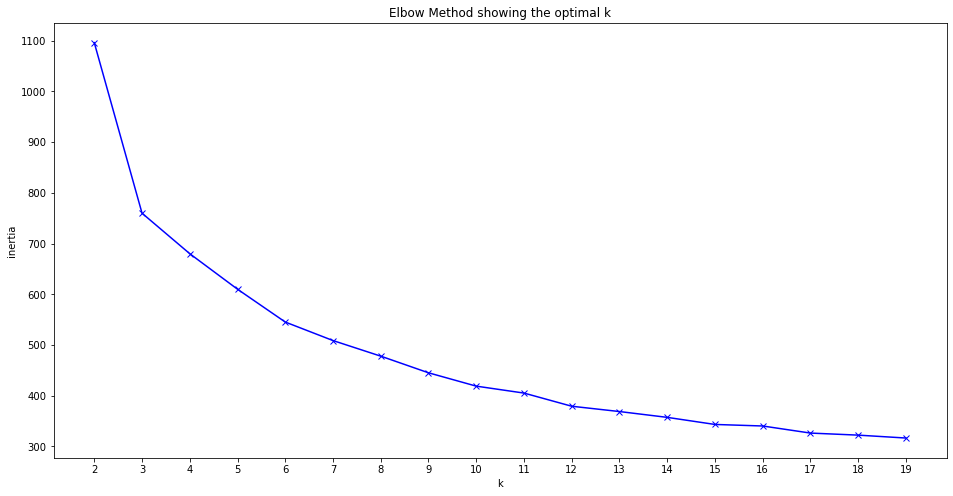

In [252]:
#Selecting the best k

K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    clusters = kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

In [253]:
# predicting clusters

k = 8

kmeans = cluster.KMeans(n_clusters=k)
clusters = kmeans.fit(X_prep)
cluster_pred = kmeans.predict(X_prep)


#Inertia
kmeans.inertia_ 

472.7674555483626

In [254]:
# Add cluster number to playlist

playlist_db_all['cluster_pred'] = cluster_pred

In [255]:
playlist_db_all.to_excel('playlist_db_all_with_audio.xlsx', sheet_name='spotify_list')  

In [256]:
playlist_db_all

,unnamed: 0,music,artist,album,audio_features_0_danceability,audio_features_0_energy,audio_features_0_key,audio_features_0_loudness,audio_features_0_mode,audio_features_0_speechiness,...,audio_features_0_valence,audio_features_0_tempo,audio_features_0_type,audio_features_0_id,audio_features_0_uri,audio_features_0_track_href,audio_features_0_analysis_url,audio_features_0_duration_ms,audio_features_0_time_signature,cluster_pred
0,0,Miniyamba,Yeahman,Shika Shika / Botanas Series,0.702,0.5080,4,-9.474,0,0.0457,...,0.659,89.004,audio_features,5LLfL25W8ELqVXOLBhkJOP,spotify:track:5LLfL25W8ELqVXOLBhkJOP,https://api.spotify.com/v1/tracks/5LLfL25W8ELq...,https://api.spotify.com/v1/audio-analysis/5LLf...,250787,4,0
1,1,We,Marava,We EP,0.867,0.4000,2,-10.431,0,0.0542,...,0.219,117.972,audio_features,0tujxzW3mEM6CnS0PK0Fcb,spotify:track:0tujxzW3mEM6CnS0PK0Fcb,https://api.spotify.com/v1/tracks/0tujxzW3mEM6...,https://api.spotify.com/v1/audio-analysis/0tuj...,215593,4,0
2,2,Quién Me Escucha,Sandra Bernardo,Quién Me Escucha,0.746,0.5300,11,-10.645,0,0.2720,...,0.574,182.020,audio_features,19e0zVRwZdpid0bGdYXxGi,spotify:track:19e0zVRwZdpid0bGdYXxGi,https://api.spotify.com/v1/tracks/19e0zVRwZdpi...,https://api.spotify.com/v1/audio-analysis/19e0...,198150,4,4
3,3,Kompaz,Rodrigo Gallardo,Harabe Daydreams I,0.788,0.4930,11,-13.009,0,0.0741,...,0.244,108.036,audio_features,0E5zTpx6xHATfDox2qMNHY,spotify:track:0E5zTpx6xHATfDox2qMNHY,https://api.spotify.com/v1/tracks/0E5zTpx6xHAT...,https://api.spotify.com/v1/audio-analysis/0E5z...,395556,4,0
4,4,"Monday (feat. LEJ, Akhenaton & Blundetto)",Biga*Ranx,1988,0.945,0.4600,11,-6.892,0,0.0573,...,0.736,130.065,audio_features,5IZBQqDymS1bDGmesVFC8N,spotify:track:5IZBQqDymS1bDGmesVFC8N,https://api.spotify.com/v1/tracks/5IZBQqDymS1b...,https://api.spotify.com/v1/audio-analysis/5IZB...,177813,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,1638,Que reste-t-il de nos amours ? - Bonus track,Stacey Kent,Raconte-moi... (Bonus Edition),0.534,0.0889,9,-17.076,1,0.0892,...,0.186,173.205,audio_features,7vY7W8DL8JSaS6aBDFHGW3,spotify:track:7vY7W8DL8JSaS6aBDFHGW3,https://api.spotify.com/v1/tracks/7vY7W8DL8JSa...,https://api.spotify.com/v1/audio-analysis/7vY7...,163510,4,6
1639,1639,Barry White,Fredda,Toutes mes aventures,0.655,0.4490,9,-8.945,0,0.0251,...,0.587,90.077,audio_features,3AOHmD0knWrkPCuu4l1Hbb,spotify:track:3AOHmD0knWrkPCuu4l1Hbb,https://api.spotify.com/v1/tracks/3AOHmD0knWrk...,https://api.spotify.com/v1/audio-analysis/3AOH...,195160,4,7
1640,1640,Raconte-moi...,Stacey Kent,Raconte-moi... (Bonus Edition),0.718,0.2550,6,-13.892,0,0.0451,...,0.273,123.971,audio_features,2lvlrhaZrPws3DSoZ14hcL,spotify:track:2lvlrhaZrPws3DSoZ14hcL,https://api.spotify.com/v1/tracks/2lvlrhaZrPws...,https://api.spotify.com/v1/audio-analysis/2lvl...,222817,4,7
1641,1641,Que reste t-il de nos amours,Cyntia M.,Bistro Blue,0.616,0.1960,0,-12.266,1,0.0553,...,0.303,121.772,audio_features,3rUVcKmdmAjJEt0Zx7nSL5,spotify:track:3rUVcKmdmAjJEt0Zx7nSL5,https://api.spotify.com/v1/tracks/3rUVcKmdmAjJ...,https://api.spotify.com/v1/audio-analysis/3rUV...,211440,4,6


# Song Recommender

In [257]:
secrets_file = open("secrets_spotify.txt","r")
string = secrets_file.read()

In [258]:
secrets_dict={} # create a dictionary

for line in string.split('\n'):
    if len(line) > 0: #this is used in case we have empty lines
        secrets_dict[line.split(':')[0]]=line.split(':')[1]

In [259]:
#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['cid'],
                                                           client_secret=secrets_dict['csecret']))

In [260]:
#import playlists
top100_songs = pd.read_excel('top100_songs_all.xlsx')
playlist_db_all = pd.read_excel('playlist_db_all_with_audio.xlsx')

#Standardize / remove columns
playlist_db_all.columns = playlist_db_all.columns.str.lower()

In [234]:
audio_features_list = []
music_search = sp.search(q=music, limit=1)

audio_features_list.append(sp.audio_features(music_search['tracks']['items'][0]['uri']))
df_audio['audio_features'] = audio_features_list
df_audio['audio_features']

# flatten audio features column
flat_list = ['audio_features']
flat_list0 = ['audio_features_0']

        #flatten to first remove list
for column in flat_list:
    flattened = pd.DataFrame(dict(df_audio[column])).transpose()
    columns = [str(col) for col in flattened.columns]
    flattened.columns = [column + '_' + colname for colname in columns]
    df_audio = pd.concat([df_audio, flattened], axis=1)
    df_audio = df_audio.drop(column, axis=1)


#flatten - then remove dict
for column in flat_list0:
    flattened = pd.DataFrame(dict(df_audio[column])).transpose()
    columns = [str(col) for col in flattened.columns]
    flattened.columns = [column + '_' + colname for colname in columns]
    df_audio = pd.concat([df_audio, flattened], axis=1)
    df_audio = df_audio.drop(column, axis=1)


df_audio.dtypes

audio_features_0_acousticness      object
audio_features_0_analysis_url      object
audio_features_0_danceability      object
audio_features_0_duration_ms       object
audio_features_0_energy            object
                                    ...  
audio_features_0_time_signature    object
audio_features_0_track_href        object
audio_features_0_type              object
audio_features_0_uri               object
audio_features_0_valence           object
Length: 109, dtype: object

In [266]:
def song_recommender():
    
    music = input("\nOne of my favourite music is...? ") 
    
    
    df_audio = pd.DataFrame()
    audio_features_list = []
    top100_songs_list = list(top100_songs['title'])

    #get a random music form the top100
    random_music_top_100 = random.choices(top100_songs_list)

    if music in top100_songs_list:
        print('Great choice. Here is another music from the Top 100: ',random_music_top_100)
    else:
        music_search = sp.search(q=music, limit=1)
        audio_features_list.append(sp.audio_features(music_search['tracks']['items'][0]['uri'])) #audio features

        #create df for audio features
        df_audio['audio_features'] = audio_features_list

        # flatten audio features column
        flat_list = ['audio_features']
        flat_list0 = ['audio_features_0']

        #flatten to first remove list
        for column in flat_list:
            flattened = pd.DataFrame(dict(df_audio[column])).transpose()
            columns = [str(col) for col in flattened.columns]
            flattened.columns = [column + '_' + colname for colname in columns]
            df_audio = pd.concat([df_audio, flattened], axis=1)
            df_audio = df_audio.drop(column, axis=1)


        #flatten - then remove dict
        for column in flat_list0:
            flattened = pd.DataFrame(dict(df_audio[column])).transpose()
            columns = [str(col) for col in flattened.columns]
            flattened.columns = [column + '_' + colname for colname in columns]
            df_audio = pd.concat([df_audio, flattened], axis=1)
            df_audio = df_audio.drop(column, axis=1)


        df_audio_features = df_audio[['audio_features_0_danceability','audio_features_0_energy',
                                                 'audio_features_0_key','audio_features_0_loudness',
                                                  'audio_features_0_mode', 'audio_features_0_speechiness',
                                                 'audio_features_0_acousticness', 'audio_features_0_instrumentalness',
                                                 'audio_features_0_liveness', 'audio_features_0_valence',
                                                 'audio_features_0_tempo', 'audio_features_0_duration_ms',
                                                 'audio_features_0_time_signature']].apply(pd.to_numeric)

        X_prep = MinMaxtransformer.transform(df_audio_features)
        X_prep = pd.DataFrame(X_prep,columns=df_audio_features.columns)

        cluster_pred = kmeans.predict(X_prep)

        df_audio['cluster_pred'] = cluster_pred

        music_cluster_df = playlist_db_all[playlist_db_all['cluster_pred'].values == df_audio['cluster_pred'].values]
        music_cluster_list = list(music_cluster_df['music'])

        random_music_spotify = random.choices(music_cluster_list)
        
       
        print('Your favourite music is not in the Top 100.')   
        print('Here is a music you might like too from spotify: ')
        print('Music: ',random_music_spotify)


In [268]:
song_recommender()


One of my favourite music is...? Burguesinha
Your favourite music is not in the Top 100.
Here is a music you might like too from spotify: 
Music:  ['Mushaboom - Remix by VV']


# Still need to increase spotify dataset